# Timeseries classification from scratch

**Author:** [hfawaz](https://github.com/hfawaz/)<br>
**Replication:** [mxochicale](https://github.com/mxochicale/)<br>
**Date created:** 2020/07/21<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.


**Logs:**
* MX: Fri 21 Jul 21:45:20 BST 2023 # For ploting. I tried plot_history(history) but needs some refactor and maybe add it in utils. https://gist.github.com/whyboris/91ee793ddc92cf1e824978cf31bb790c
* MX: Sun 23 Jul 11:35:21 BST 2023 # Add plot and dependencies for confusion matrix 


## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import itertools


## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).


```
$PATH/FordA$ tree -s
[       4096]  .
├── [    7364408]  FordA_TEST.tsv
└── [   20094049]  FordA_TRAIN.tsv
```



### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [3]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

print(f'Train data: x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'Test data: x_test {x_test.shape}, {y_test.shape}')

Train data: x_train: (3601, 500), y_train: (3601,)
Test data: x_test (1320, 500), (1320,)


In [4]:
## Reducing train and test data size

lenght_of_time_series=500 # Original size # 500
train_size=3600 # Original size # 3601
print(type(x_train))
print(x_train.shape)
x_train = np.resize(x_train, (train_size,lenght_of_time_series))
print(x_train.shape)

print(y_train.shape)
y_train = np.resize(y_train, (train_size,))
print(y_train.shape)

test_size = 1300 # Original size #1320
print(type(x_test))
print(x_test.shape)
x_test = np.resize(x_test, (test_size,lenght_of_time_series))
print(x_test.shape)

print(y_test.shape)
y_test = np.resize(y_test, (test_size,))
print(y_test.shape)



<class 'numpy.ndarray'>
(3601, 500)
(3600, 500)
(3601,)
(3600,)
<class 'numpy.ndarray'>
(1320, 500)
(1300, 500)
(1320,)
(1300,)


## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

idx: 300
c: -1
    class -1 with c_x_train.shape (1845, 500)


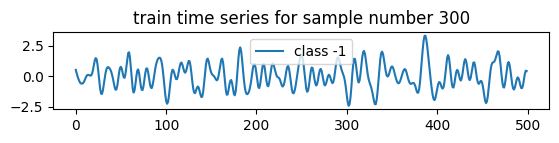

c: 1
    class 1 with c_x_train.shape (1755, 500)


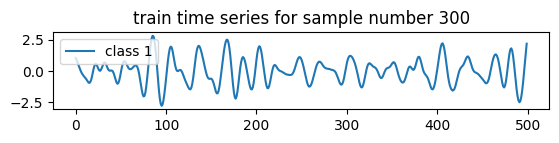

In [7]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

start_sample_numbers=300
end_interval=1

for idx in range(start_sample_numbers,start_sample_numbers+end_interval):
    print(f'idx: {idx}')    
    
    for c in classes:
        print(f'c: {c}')
        # print(f'    y_train == c; {y_train == c}')
        c_x_train = x_train[y_train == c]
        print(f'    class {c} with c_x_train.shape {c_x_train.shape}')
        plt.figure().set_figheight(1)
        plt.plot(c_x_train[idx], label="class " + str(c))
        plt.legend(loc="best")
        plt.title(f'train time series for sample number {idx}')
        plt.show()
        plt.close()
    plt.close()

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [8]:
print(f'x_train.shape: {x_train.shape}, x_test.shape {x_test.shape}')

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


print(f'x_train.shape: {x_train.shape}, x_test.shape {x_test.shape}')

x_train.shape: (3600, 500), x_test.shape (1300, 500)
x_train.shape: (3600, 500, 1), x_test.shape (1300, 500, 1)


Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [9]:
num_classes = len(np.unique(y_train))
print(f'y_train.shape: {y_train.shape}')
print(f'num_classes: {num_classes}')

y_train.shape: (3600,)
num_classes: 2


Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [10]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [11]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

In [12]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    print(f'input_layer: {input_layer}')

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)
    print(f'output_layer: {output_layer}')

    return keras.models.Model(inputs=input_layer, outputs=output_layer)



In [13]:
input_shape=x_train.shape[1:]
print(f'input_shape: {input_shape}')
model = make_model(input_shape=input_shape)
keras.utils.plot_model(model, show_shapes=True)

input_shape: (500, 1)
input_layer: KerasTensor(type_spec=TensorSpec(shape=(None, 500, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
output_layer: KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train the model

In [14]:
# epochs = 2
epochs = 10
# epochs = 50
# epochs = 100
# epochs = 300
# epochs = 500

# batch_size = 16
# batch_size = 32
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    #keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# fit network
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

# Model training APIs (methods for compile, fit, evaluate)
# https://keras.io/api/models/model_training_apis/

Epoch 1/10


45/45 [==============================] - 3s 41ms/step - loss: 0.6517 - sparse_categorical_accuracy: 0.5993 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.4694 - lr: 0.0010
Epoch 2/10
 5/45 [==>...........................] - ETA: 1s - loss: 0.5495 - sparse_categorical_accuracy: 0.7063

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 2s 37ms/step - loss: 0.5222 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.7875 - val_sparse_categorical_accuracy: 0.4694 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - 2s 35ms/step - loss: 0.4815 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.7868 - val_sparse_categorical_accuracy: 0.4694 - lr: 0.0010
Epoch 4/10
45/45 [==============================] - 2s 35ms/step - loss: 0.4388 - sparse_categorical_accuracy: 0.7844 - val_loss: 0.7679 - val_sparse_categorical_accuracy: 0.4694 - lr: 0.0010
Epoch 5/10
45/45 [==============================] - 2s 36ms/step - loss: 0.4233 - sparse_categorical_accuracy: 0.7948 - val_loss: 0.7324 - val_sparse_categorical_accuracy: 0.4694 - lr: 0.0010
Epoch 6/10
45/45 [==============================] - 2s 36ms/step - loss: 0.4188 - sparse_categorical_accuracy: 0.7934 - val_loss: 0.6861 - val_sparse_categorical_accuracy: 0.4764 - lr: 0.0010
Epoch 7/10
45/45 [==============================] -

## Plot the model's training and validation loss

history.params: {'verbose': 1, 'epochs': 10, 'steps': 45}
history.history.keys(): dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


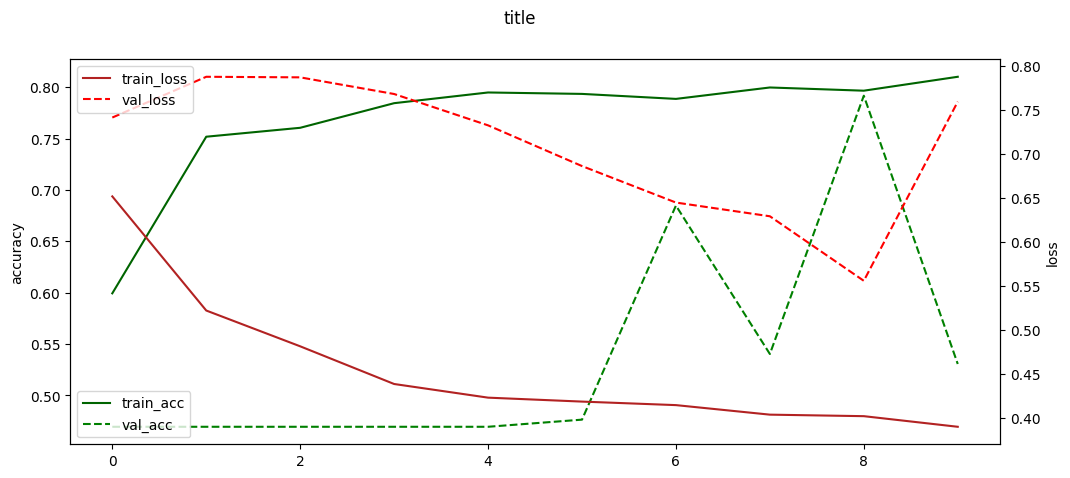

In [15]:
metric = "sparse_categorical_accuracy"

print(f'history.params: {history.params}' )
print(f'history.history.keys(): {history.history.keys()}')

fig = plt.figure(figsize=(12,5))
fig.suptitle("title")
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

ax1.plot(history.history['sparse_categorical_accuracy'], color='darkgreen', label = 'train_acc', linestyle='solid')
ax1.plot(history.history['val_sparse_categorical_accuracy'], color='green', label = 'val_acc',linestyle='--')

ax2.plot(history.history['loss'], color='firebrick', label = 'train_loss', linestyle='solid')
ax2.plot(history.history['val_loss'], color='red', label = 'val_loss',linestyle='--')

ax1.set_ylabel("accuracy")
ax2.set_ylabel("loss")

ax1.legend(loc = 'lower left')
ax2.legend(loc = 'upper left')

plt.show()



## Evaluate model on test data

In [16]:
loaded_model = keras.models.load_model("best_model.h5")
test_loss, test_acc = loaded_model.evaluate(x_test, 
                                            y_test, 
                                            batch_size=batch_size,
                                            verbose=1)

print(f'=============================')
print(f'=============================')
print(f'Test accuracy {test_acc*100} and Test loss {test_loss*100}')
print(f'=============================')
print(f'=============================')

21/21 [==============================] - 0s 7ms/step - loss: 0.5552 - sparse_categorical_accuracy: 0.7854
Test accuracy 78.53845953941345 and Test loss 55.519115924835205


In [17]:
#Understanding your h5 model > https://www.youtube.com/watch?v=_a-UYLfF6TE
print(loaded_model.summary())
# for layer in loaded_model.layers:
    # print(layer.name)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 500, 64)           256       
                                                                 
 batch_normalization (Batch  (None, 500, 64)           256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 500, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           12352     
                                                                 
 batch_normalization_1 (Bat  (None, 500, 64)           256       
 chNormalization)                                            

In [19]:
## Load model
predictions = loaded_model.predict(x_test)

 1/41 [..............................] - ETA: 3s

41/41 [==============================] - 0s 4ms/step


x_test.shape: (1300, 500, 1), predictions.shape:  (1300, 2)
Ground truth for test timeseries:  1
Predictions for each class:

class: 0  probability:  0.38013515
class: 1  probability:  0.61986494
len(predicted_labels): 1300
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 1]


Text(0.5, 55.65546539603249, 'Predicted label')

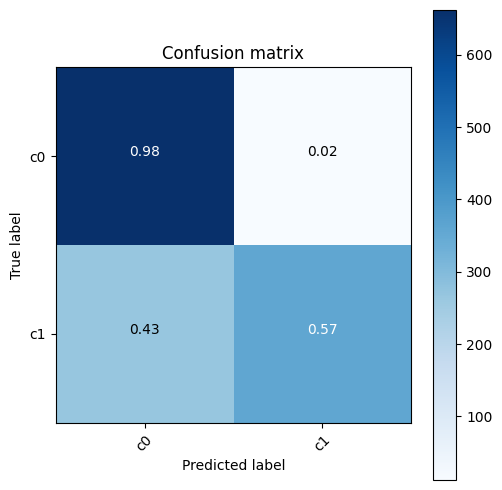

In [20]:
print(f'x_test.shape: {x_test.shape}, predictions.shape:  {predictions.shape}')

index = 100 # up to 9999
print('Ground truth for test timeseries: ',y_test[index])
print('Predictions for each class:\n')
for i in range(2):
    print('class:', i, ' probability: ', predictions[index][i])

# For each sample timeseries in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]
print(f'len(predicted_labels): {len(predicted_labels)}')



test_pred = np.argmax(predictions, axis=1)
print(test_pred)
print(y_test)

# cm = sklearn.metrics.confusion_matrix(y_test, test_pred)
cm = sklearn.metrics.confusion_matrix(y_test, test_pred)


class_names = ['c0', 'c1']

figure = plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix.
cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
# Use white text if squares are dark; otherwise black.
threshold = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')



We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.